# BMEN4480 Assignment 2 
## Author: Lauren Friend (lef2148) Collaborators: [Cameron Park]

In [1]:
# imports
import matplotlib
import matplotlib.pyplot as plt
import gzip
import pandas as pd
import sklearn
import scanpy as sc
import scipy
import numpy as np
import os
import anndata
import statistics
import seaborn as sns
sns.set_style("whitegrid")
import bhtsne
import phenograph

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


### Load Data

In [2]:
path=os.getcwd()
PBMC6k_path = f"{path}/pbmc_6Kcells_500genes.txt"
PBMC6k = pd.read_csv(PBMC6k_path,sep='\t')

In [3]:
cellid= pd.DataFrame(PBMC6k['CELLID'])
cellid_T = cellid.transpose()
PBMC6k = PBMC6k.drop(columns='CELLID')
PBMC6k_T = PBMC6k.transpose()

In [4]:
print(f"matrix shapes genesXcells format: {PBMC6k.shape} and {cellid.shape}")
print(f"transposed matrix shapes cellsXgenes format: {PBMC6k_T.shape} and {cellid_T.shape}")

matrix shapes genesXcells format: (500, 6825) and (500, 1)
transposed matrix shapes cellsXgenes format: (6825, 500) and (1, 500)


### Global Normalization

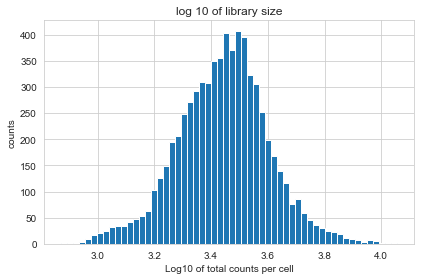

In [5]:
# Distrbution of library size (total counts per cell) 
log10_lib_size = np.log10(PBMC6k_T.sum(axis=1))
plt.hist(log10_lib_size,bins='auto')
plt.title('log 10 of library size')
plt.xlabel('Log10 of total counts per cell')
plt.ylabel('counts')
plt.tight_layout()

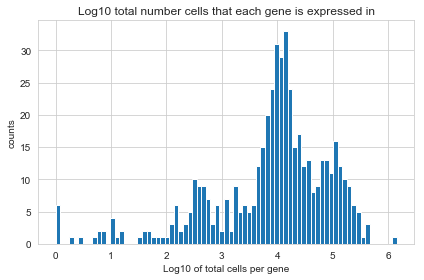

In [7]:
log10_gene_expr = np.log10(PBMC6k_T.sum(axis=0))
plt.hist(log10_gene_expr,bins=75, range=(0,log10_gene_expr.max()))
plt.title('Log10 total number cells that each gene is expressed in')
plt.xlabel('Log10 of total cells per gene')
plt.ylabel('counts')
plt.tight_layout()

In [8]:
#threshhold at 2
#PBMC6k_TF = PBMC6k_T[log10_gene_expr.index[log10_gene_expr > 2]]

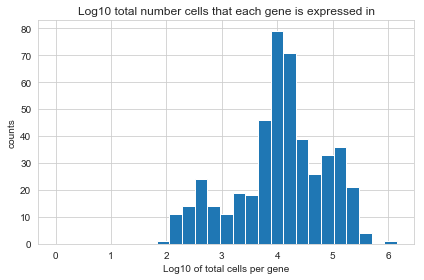

In [10]:
# log10_gene_expr = np.log10(PBMC6k_TF.sum(axis=0))
# plt.hist(log10_gene_expr,bins='auto', range=(0,log10_gene_expr.max()))
# plt.title('Log10 total number cells that each gene is expressed in')
# plt.xlabel('Log10 of total cells per gene')
# plt.ylabel('counts')
# plt.tight_layout()

In [8]:
#normalizing the data & taking log10 
ms = PBMC6k_T.sum(axis=1) #library size
norm_df = PBMC6k_T.div(ms, axis=0).mul(np.median(ms), axis=0) 
log_df = np.log(0.1+ norm_df)

## Q1a
Log transform the data and performPCA,followed by t-SNE or UMAP on the top 20 PCs. Plot the 2D or 3D embedding [15pt].

In [9]:
#perform PCA with 20 PC's
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_projections = pd.DataFrame(pca.fit_transform(log_df),
                index=log_df.index)

In [10]:
#t-SNE on the top 20 PC's
tsne = pd.DataFrame(bhtsne.tsne(pca_projections, perplexity=30), 
            index=log_df.index, columns=['x', 'y'])

Text(0.5, 1.0, 'Tsne representation of PCA results')

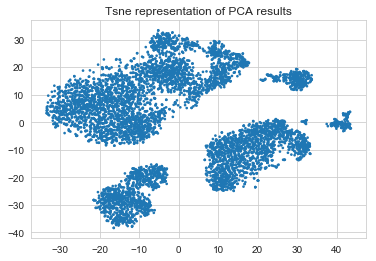

In [11]:
#plotting the 2D embedding
plt.scatter(tsne['x'], tsne['y'], s=7, edgecolors='none' )
plt.title('Tsne representation of PCA results')

## Q1b. 
Is 20 a good choice for the number of PCs? [bonus 5 pt]

     From the exploratory line graph below you can see that the kneepoint is lower than 20, meaning the final PC's are supurfluous. I would choose ~12-15 for the number of PC's 

In [12]:
#perform PCA with a larger number of PCs
pca_test = PCA(n_components=50)
pca_test.fit(log_df.values)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

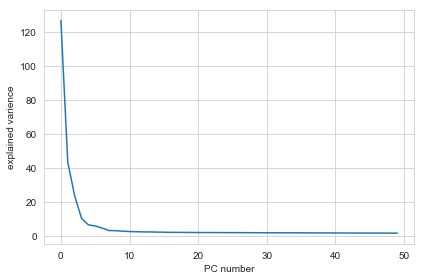

In [13]:
# Get Eiganvectors
eig_vectors = pca_test.components_
# Get Eiganvalues
eig_values = pca_test.explained_variance_
# plot
plt.plot(eig_values)
plt.xlabel('PC number')
plt.ylabel('explained varience')
plt.tight_layout()

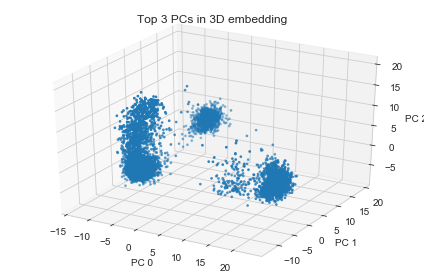

In [14]:
from mpl_toolkits.mplot3d import Axes3D
# Plot initialisation
colors=['r','g','b']
fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_projections[0], pca_projections[1], pca_projections[2], s=3, cmap='sprectral')
ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 2')
ax.set_title('Top 3 PCs in 3D embedding')
fig.tight_layout()

## Q2.
Cluster cells using the K-means method and color the embedding from Q1 with clusterIDs. Justify your choice of K 

in the K=10 graphs, the clusters appeared to be more separated on the tsne (more separated in the high dimentional space as well) and when the expression of the top 5 genes were plotted, the genes appeared to be different in cell type based on the gene expression. I was torn of which number to choose between k=5 and k=10.

to double check, I plotted the sum of the squared distances to the nearest cluster center which is given in sklearn as intertia. The elbow point of this graph is K=7. 

combining the information from the sum of squared distances and the gene co-expression, I decided on <b>clusters=9<b>.

In [20]:
from sklearn.cluster import KMeans
kmeans_5 = KMeans(n_clusters=5, random_state=2,algorithm="full").fit_predict(log_df)
kmeans_10 = KMeans(n_clusters=10, random_state=2,algorithm="full").fit_predict(log_df)
kmeans_15 = KMeans(n_clusters=15, random_state=2,algorithm="full").fit_predict(log_df)
kmeans_20 = KMeans(n_clusters=20, random_state=2,algorithm="full").fit_predict(log_df)

In [21]:
kmeans_5_s = pd.Series(kmeans_5,index=tsne.index)
kmeans_10_s = pd.Series(kmeans_10,index=tsne.index)
kmeans_15_s = pd.Series(kmeans_15,index=tsne.index)
kmeans_20_s = pd.Series(kmeans_20,index=tsne.index)

In [22]:
kmeans_results=[kmeans_5,kmeans_10,kmeans_15,kmeans_20]
kmeans_dataframes=[kmeans_5_s,kmeans_10_s,kmeans_15_s,kmeans_20_s]
clusters=[5,10,15,20]

In [23]:
def plot_kmeans(kmeans,kmeans_df, num):
    for i,cluster in enumerate(set(kmeans)):
        cells=kmeans_df.index[kmeans==cluster]
        ax[num].scatter(tsne.loc[cells,'x'],tsne.loc[cells,'y'],edgecolors='none',label=cluster,s=3)
        ax[num].set_title(f'{clusters[num]} clusters',fontsize=20)
        ax[num].legend(markerscale=10)

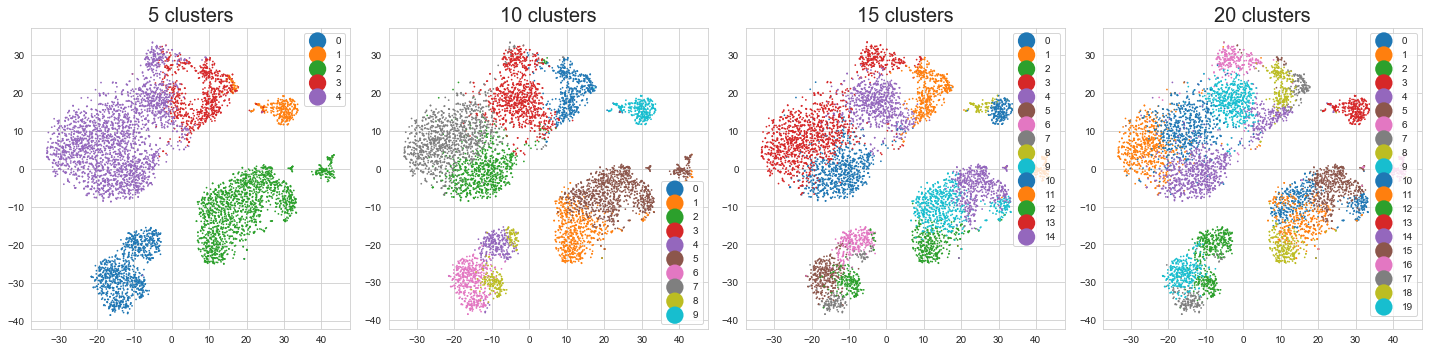

In [24]:
fig, ax = plt.subplots(1,4,figsize=(5*4,5))
num=0
for kmeans_data,datafr in zip(kmeans_results,kmeans_dataframes):
    plot_kmeans(kmeans_data,datafr,num)
    num+=1
fig.tight_layout()

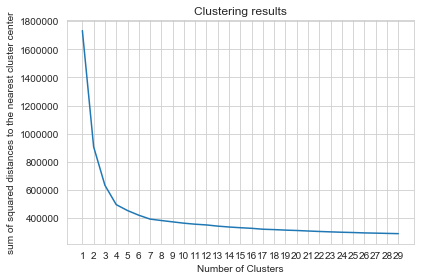

In [25]:
num_clusters = [x for x in range(1,30)]
inertias = []
for k in num_clusters:
    clustering_algorithm = KMeans(n_clusters=k, random_state=2,algorithm="full")
    # Fit model to samples
    clustering_algorithm.fit(pca_projections)
    #sum of the squared distances to the nearest cluster center
    inertias.append(clustering_algorithm.inertia_)

plt.plot(num_clusters, inertias)
plt.xlabel('Number of Clusters')
plt.ylabel('sum of squared distances to the nearest cluster center')
plt.xticks(num_clusters)
plt.title('Clustering results')
plt.tight_layout()

In [27]:
#test different genes and see if genes that should be coexpressed are expressed in same cluster and genes that should not be coexpressed are not coexpressed

In [26]:
def sloppy_gene_expression(kmeans,log_data,cell_id,num_clusters):
    fig = plt.figure(figsize=[5*4, 7*4])
    for cluster in range(num_clusters):
        cluster_df = log_data.loc[kmeans.index[kmeans==cluster]]
        cols = cluster_df.sum(axis=0)
        top10genes=[cell_id.loc[x][0] for x in cols.nlargest(10).index]
        ax = fig.add_subplot(7, 5, cluster+1)
        ax.bar(top10genes,cols.nlargest(10))
        ax.tick_params(labelrotation=45)
    fig.tight_layout()

In [60]:
cellid[cellid['CELLID']=='MALAT1'].index #this is the most expressed in every cluster 

Int64Index([271], dtype='int64')

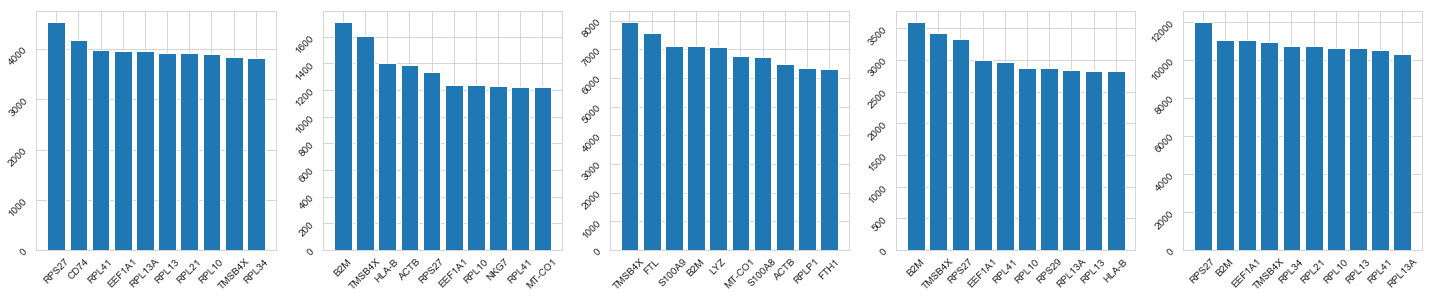

In [56]:
sloppy_gene_expression(kmeans_5_s,log_df.drop(columns=[271]),cellid,5)

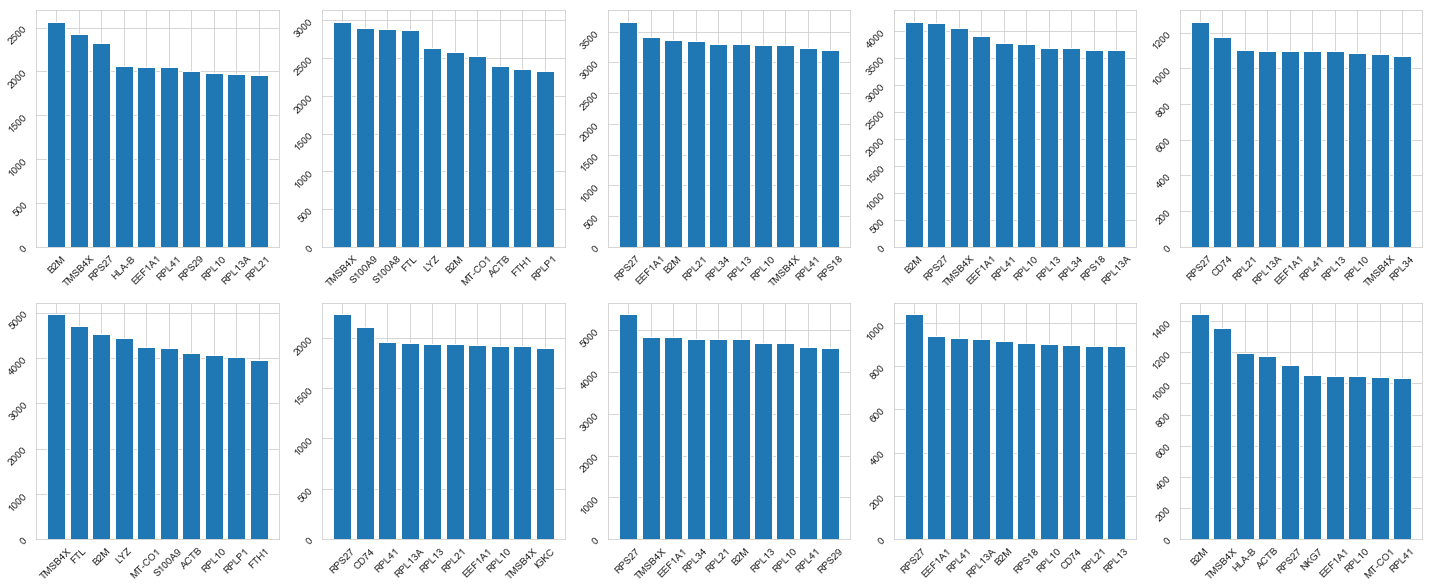

In [57]:
sloppy_gene_expression(kmeans_10_s,log_df.drop(columns=[271]),cellid,10)

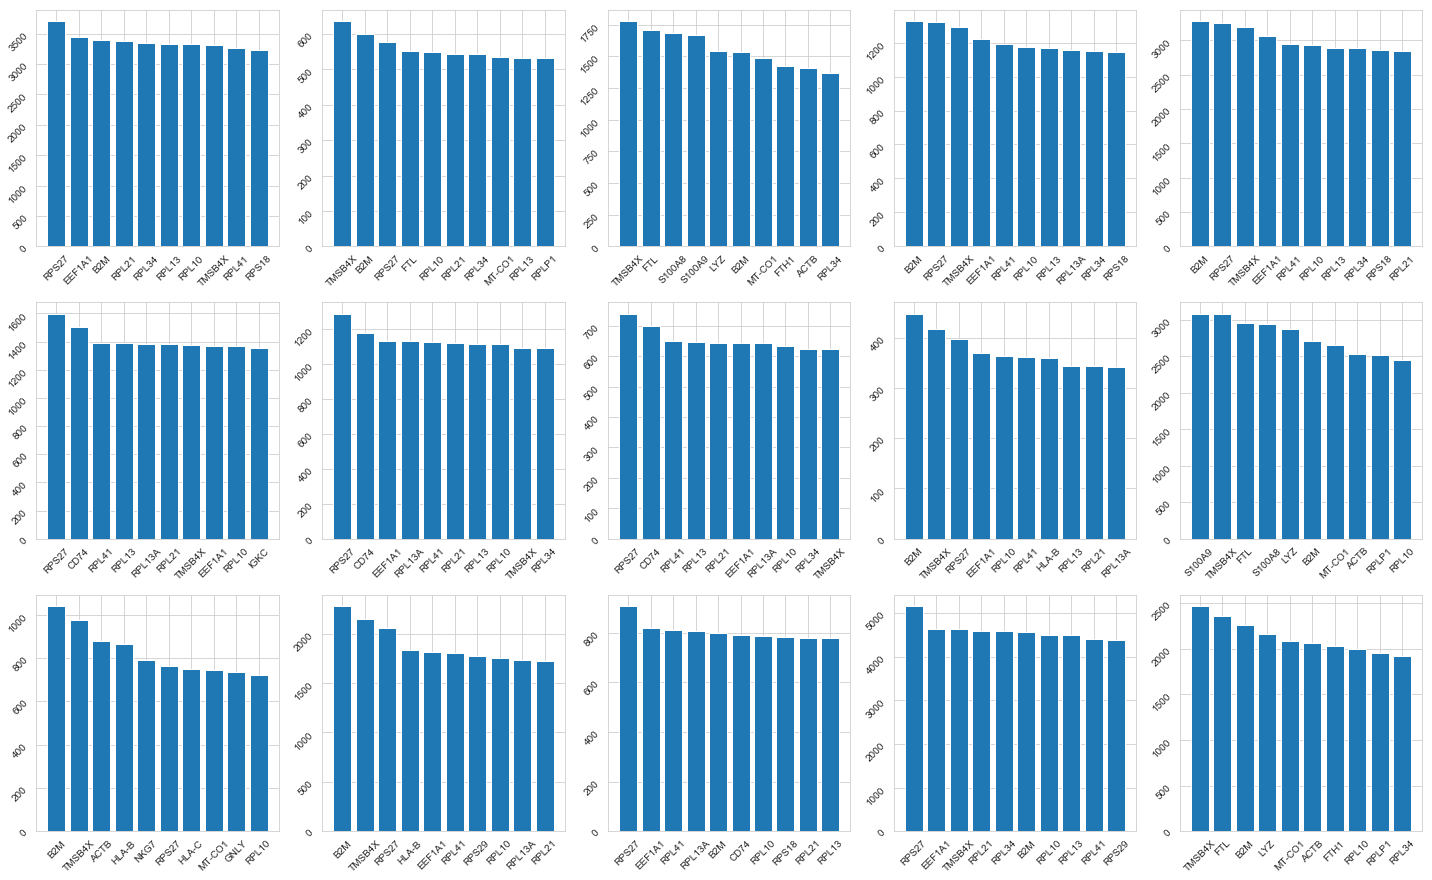

In [58]:
sloppy_gene_expression(kmeans_15_s,log_df.drop(columns=[271]),cellid,15)

In [64]:
kmeans_9 = KMeans(n_clusters=9, random_state=2,algorithm="full").fit_predict(log_df.drop(columns=[271]))
kmeans_9_s = pd.Series(kmeans_9,index=tsne.index)

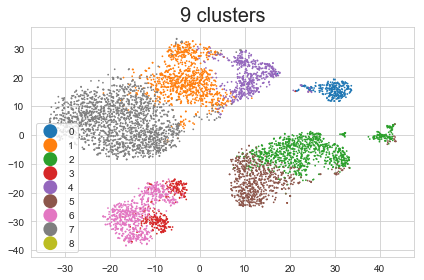

In [68]:
for i, cluster in enumerate(set(kmeans_9)):
    cells = kmeans_9_s.index[kmeans_8==cluster]
    plt.scatter(tsne.loc[cells,'x'],tsne.loc[cells,'y'],edgecolors='none',label=cluster,s=3)
    plt.title('9 clusters',fontsize=20)
    plt.legend(markerscale=8,loc=0)
    plt.tight_layout()
    

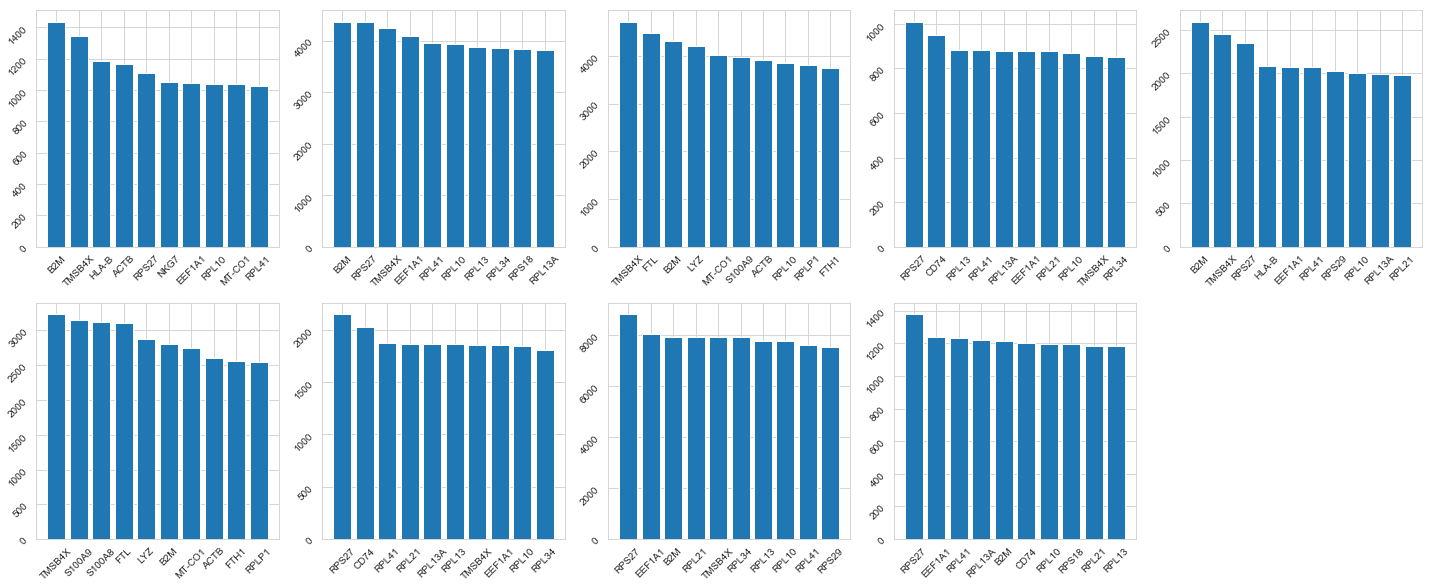

In [70]:
sloppy_gene_expression(kmeans_9_s,log_df.drop(columns=[271]),cellid,9)

### Justify choice of K: robustness analysis 

I tried to do this and was not actually implimented yet- will try again on the next HW! 

can be seen in this article: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3089-6#:~:text=Clustering%20algorithms%20are%20generally%20used,similarity%20between%20each%20object%20pair.&text=The%20metric%20we%20introduce%2C%20which,a%20range%20of%20these%20settings.

In [211]:
# from collections import OrderedDict 
# kmeans_results = OrderedDict((int(x),[]) for x in pca_projections.index)
# kmeans_cluster_results = OrderedDict((int(x),[]) for x in range(20))

In [206]:
# for j in range(100):
#     test_df = pca_projections.sample(frac=(1/3),replace=False,axis='index')
#     kmeans = KMeans(n_clusters=5, random_state=0,algorithm="full").fit_predict(test_df)
#     for cell,cluster in zip([int(x) for x in test_df.index],kmeans):
#         kmeans_results[cell].append(cluster)

In [222]:
# for j in range(50):
#     test_df = pca_projections.sample(frac=(1/3),replace=False,axis='index')
#     kmeans = KMeans(n_clusters=10, random_state=0,algorithm="full").fit_predict(test_df)
#     for cluster in (kmeans):
#         kmeans_cluster_results[cluster].append(list(test_df.index[kmeans==cluster]))

In [ ]:
# from statistics import mode
# robustness = OrderedDict()
# robustness.keys=kmeans_results.keys()

# for key in kmeans_results.keys():
#     results = kmeans_results[key]
#     most_freq = mode(results)
#     num_appearance = len([x for x in results if x==most_freq])
#     len_result = len(results)
#     num_appearance/len_result*100

## Q3
Compute a 30-NN(nearestneighbor)graph between cells. Plot a heat map of the adjacency matrix for the graph [10 pts]. Justify your distance metric [bonus 5 pts].

#### Justification:

from the graphs and the standard deviation in the column sums, all of the metrics performed the same. I chose Manhattan (L1) over Euclidian (L2) because Euclidian can be sensitive to average expression level, which I infer is an issue in this dataset based on my findings in the kmeans cluster. It makes no difference in this situation, but for pipeline reusability it is important to consider future dataset's differences.

In [31]:
from sklearn.neighbors import kneighbors_graph
#sparse weight matricies
knn_minkowski = kneighbors_graph(log_df,n_neighbors=30,mode='distance') 
knn_manhattan = kneighbors_graph(log_df,n_neighbors=30,p=1,mode='distance',metric='euclidean')
knn_euclidian = kneighbors_graph(log_df,n_neighbors=30,p=2,mode='distance',metric='euclidean')

In [32]:
knn_minkowski_graph = pd.DataFrame(knn_minkowski.todense()) #DF of dense weight matrix
knn_manhattan_graph = pd.DataFrame(knn_manhattan.todense()) #DF of dense weight matrix
knn_euclidian_graph = pd.DataFrame(knn_euclidian.todense()) #DF of dense weight matrix

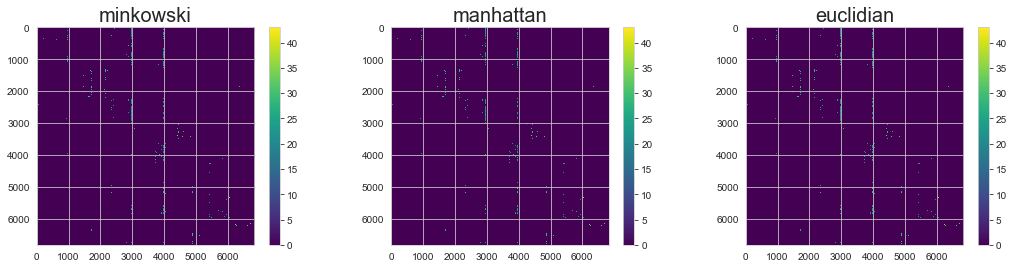

In [33]:
titles=['minkowski','manhattan','euclidian']
fig, axs = plt.subplots(1,3,figsize=(6*3,4))
axs=axs.ravel()
for i, metric in enumerate([knn_minkowski_graph,knn_manhattan_graph,knn_euclidian_graph]):
    j=axs[i].imshow(metric,cmap='viridis')
    axs[i].set_title(titles[i],fontsize=20)
    plt.colorbar(j, ax=axs[i])
    

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


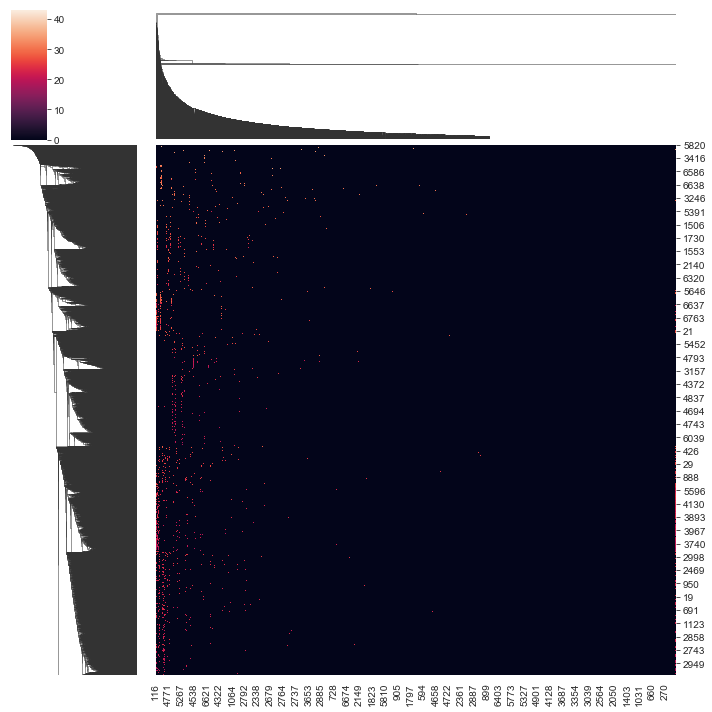

In [33]:
import sys
sys.setrecursionlimit(100000)
sns.clustermap(knn_manhattan.todense())

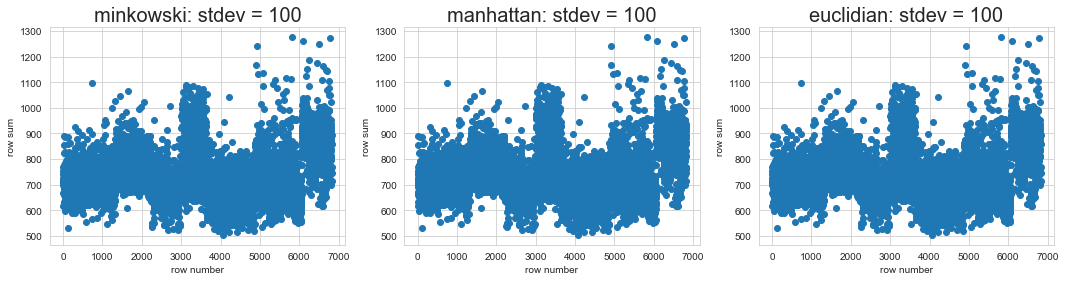

In [30]:
titles=['minkowski','manhattan','euclidian']
fig, axs = plt.subplots(1,3,figsize=(6*3,4))
axs=axs.ravel()
for i, metric in enumerate([knn_minkowski_graph,knn_manhattan_graph,knn_euclidian_graph]):
    j=axs[i].scatter(metric.index,metric.sum(axis=1))
    stdev = statistics.stdev(metric.sum(axis=1))
    axs[i].set_title(f"{titles[i]}: stdev = {round(stdev)}",fontsize=20)
    axs[i].set_xlabel('row number',fontsize=10)
    axs[i].set_ylabel('row sum',fontsize=10)

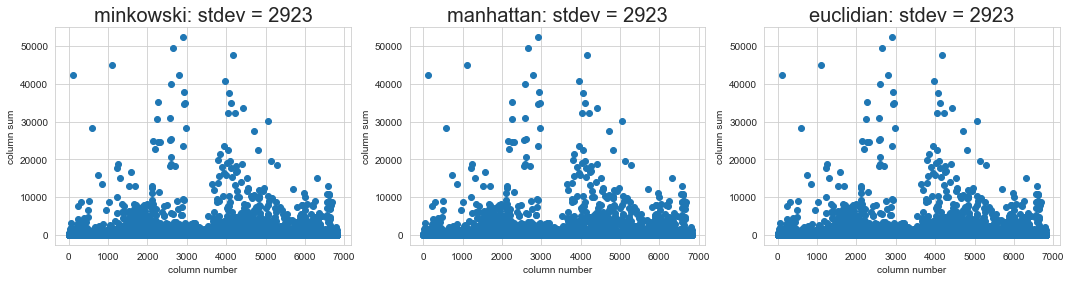

In [31]:
titles=['minkowski','manhattan','euclidian']
fig, axs = plt.subplots(1,3,figsize=(6*3,4))
axs=axs.ravel()
for i, metric in enumerate([knn_minkowski_graph,knn_manhattan_graph,knn_euclidian_graph]):
    j=axs[i].scatter(metric.columns,metric.sum(axis=0))
    stdev = statistics.stdev(metric.sum(axis=0))
    axs[i].set_title(f"{titles[i]}: stdev = {round(stdev)}",fontsize=20)
    axs[i].set_xlabel('column number',fontsize=10)
    axs[i].set_ylabel('column sum',fontsize=10)

## Q4
Cluster cells using a graph-based algorithm such as Louvain with the kNN graph from Q3. Color the embedding with cluster IDs. How does it compare to K-means? [20 pts]

This clustering algorithm produced more clusters than Kmeans, but the clusters look much more separated with the exception of a few, which have a lot of spread. 

In [34]:
communities, graph, Q = phenograph.cluster(knn_manhattan_graph,k=30) #manhattan distance

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 86.33599090576172 seconds
Jaccard graph constructed in 1.7861359119415283 seconds
Wrote graph to binary file in 0.8814518451690674 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.793789
Louvain completed 21 runs in 1.6267030239105225 seconds
PhenoGraph complete in 90.6575927734375 seconds


In [35]:
communities = pd.Series(communities,index=log_df.index)
print("number of clusters is: ",max(communities))

number of clusters is:  10


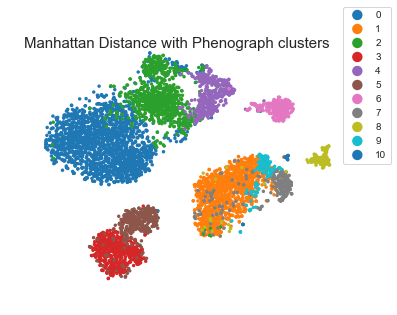

In [36]:
fig1, ax = plt.subplots(1,1, figsize=(5,4))
for i, cluster in enumerate(set(communities)):
    cells = communities.index[communities == cluster]
    #plot with a different color for each cluster
    ax.scatter(tsne.loc[cells, 'x'], tsne.loc[cells,'y'], 
            s=12,edgecolors='none', label=cluster)

    # Clean up
    ax.set_axis_off()
    sns.despine()

leg = fig1.legend(loc=1, markerscale=3)
bb= leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
xOffset = .03
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
fig1.suptitle("Manhattan Distance with Phenograph clusters",fontsize=15)
fig1.tight_layout()

In [79]:
cellid[cellid['CELLID']=='FTL'].index #this is the most expressed in every cluster 

Int64Index([184], dtype='int64')

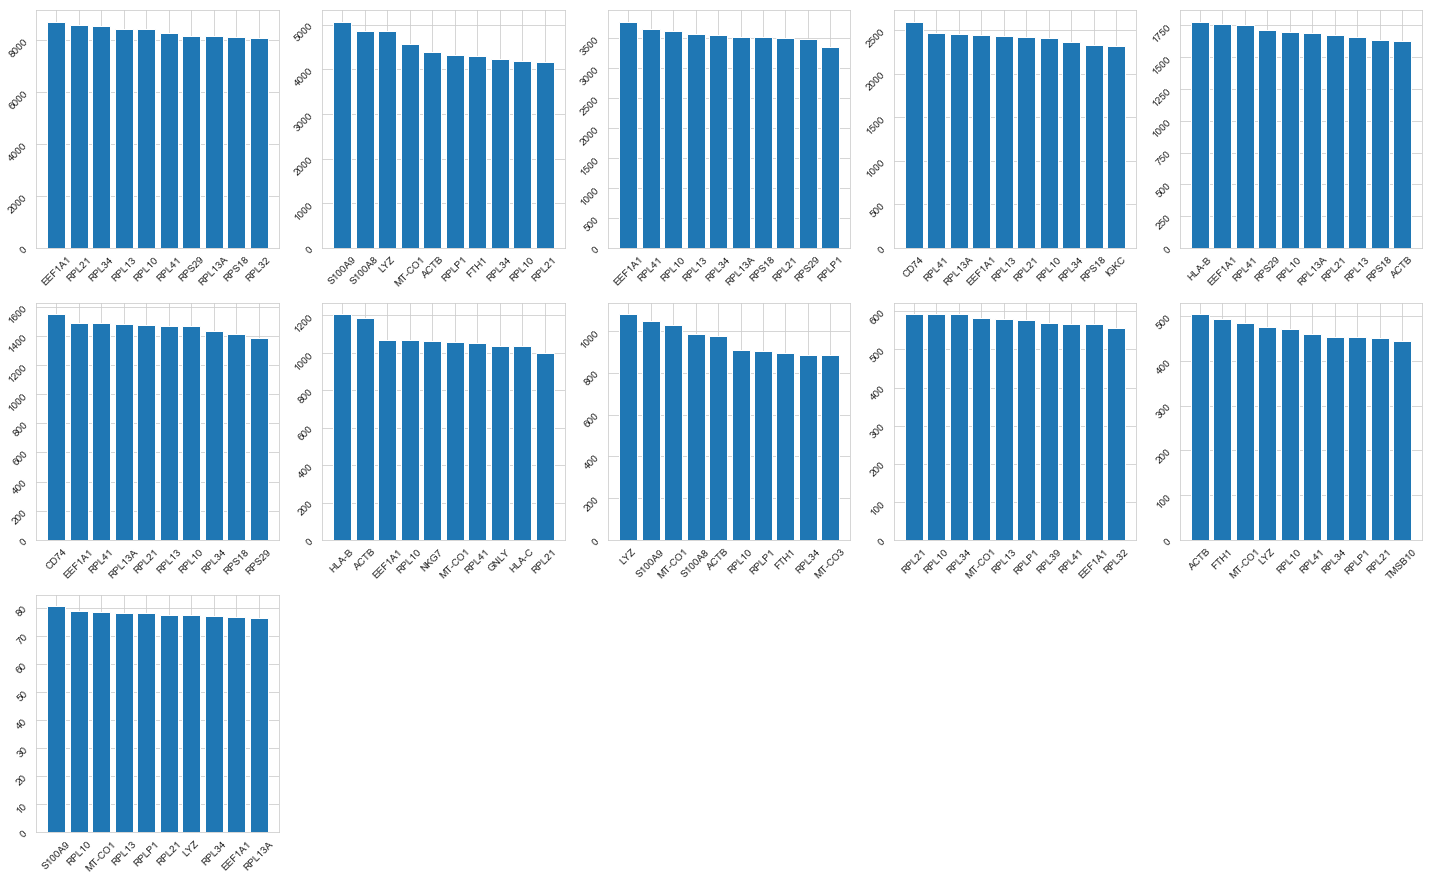

In [80]:
sloppy_gene_expression(communities,log_df.drop(columns=[184,90,271,467,408]),cellid,11)



## Q5a.
Perform a t-test to find differentially expressed genes(DEGs)in a cluster of your choice. Color the embedding with the expression of the top 5 DEGs [20 pts]

In [90]:
log_cluster_3_df=log_df.drop(columns=[271]).loc[communities.index[communities == 3]] #log transformed df of phenograph cluster 0
log_cluster_others_df=log_df.drop(columns=[271]).loc[communities.index[communities != 3]] #log transformed df of other clusters 

In [91]:
test,pval = scipy.stats.ttest_ind(log_cluster_3_df,log_cluster_others_df, axis=0, equal_var=False)
top5_test=np.argsort(test)[-5:]

In [92]:
top5=list(top5_test)
top5.reverse()
for gene_id in top5:
    print(cellid.iloc[gene_id][0])

IGKC
CD74
CD79A
HLA-DRA
HLA-DPA1


In [84]:
def graph_ttest_expression(gene_list,log_df,tsne):
    fig, ax = plt.subplots(1,5,figsize=(5*5,4))
    for i,gene in enumerate(gene_list):
        gene_expression=log_df[gene]
        ax[i].scatter(tsne.loc[:,'x'], tsne.loc[:,'y'], s=3, cmap=matplotlib.cm.Spectral_r, c=gene_expression)
        ax[i].set_title(f"{cellid.iloc[gene][0]}",fontsize=15)
    fig.tight_layout()

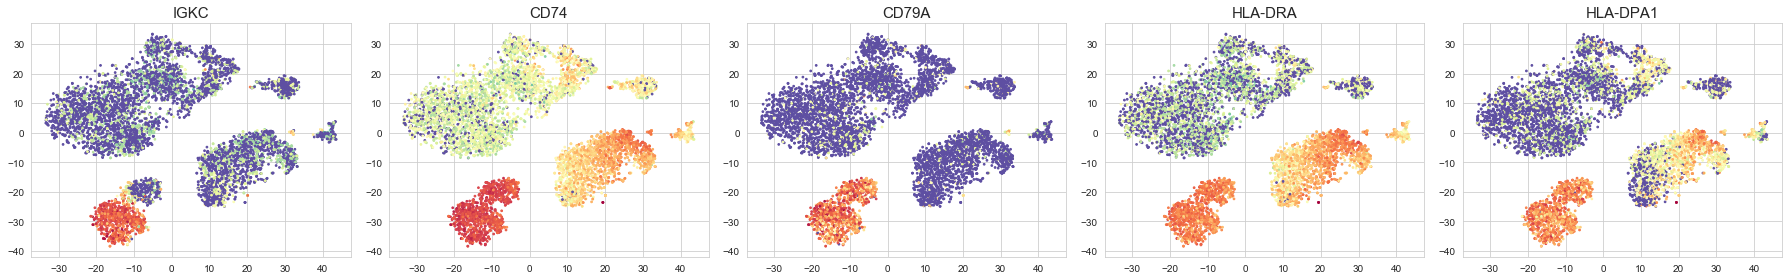

In [93]:
graph_ttest_expression(top5,log_df,tsne)


## Q5b. 
How would you characterize the cluster [5 pts]?

reference: https://www.nature.com/articles/3880133.pdf?origin=ppub

--> this cluster is showing higher expression in genes such as HLA-DRA and HLA-DPA1 which are highly expressed in leukocytes and CD74 and CD79A which are known B-cell markers. Finally, IGKC is expressed in light chains for antibodies. I would charicterize this cluster as immune cells. 



## Q5c.
Which other differential expression method might be appropriate for the expression distribution in this data? [bonus 15pt]

I think that due to the shape of our data and the clustering results, we should use MAST for our alternative differential expression analysis.